## Camera Calibration

In [1]:
# directory camera_cal
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)[...,::-1]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)

In [3]:
print(objpoints[0][0])
print(imgpoints[0][0])

[ 0.  0.  0.]
[[  88.68092346  138.59263611]]


## Undistort Image

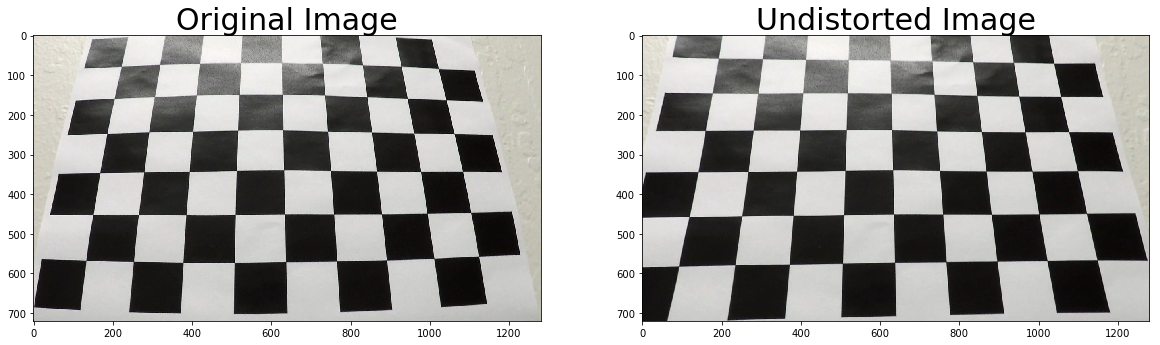

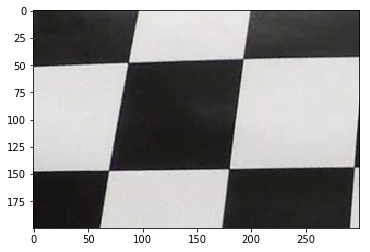

In [46]:
# img = cv2.imread('test_images/straight_lines1.jpg')[...,::-1]
img = cv2.imread('camera_cal/calibration3.jpg')[...,::-1]


def undistort_function(img, objpoints, imgpoints):

    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    return cv2.undistort(img, mtx, dist, None, mtx)

dst = undistort_function(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

im_crop = img[200:400, 100:400]
plt.figure()
plt.imshow(im_crop)


## Color and gradient threshold

In [55]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
#     hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
#     s_channel = hsv[:,:,1]
#     v_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
#     return [color_binary, combined_binary]
    return combined_binary

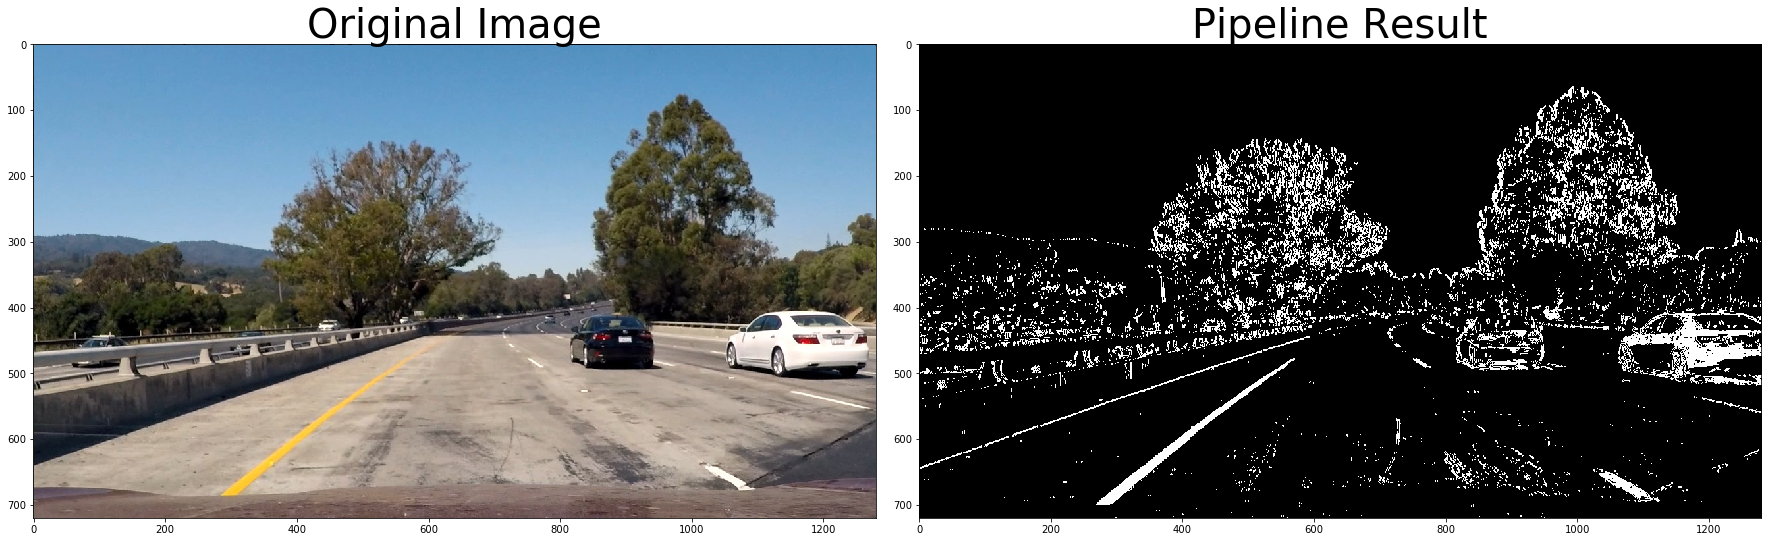

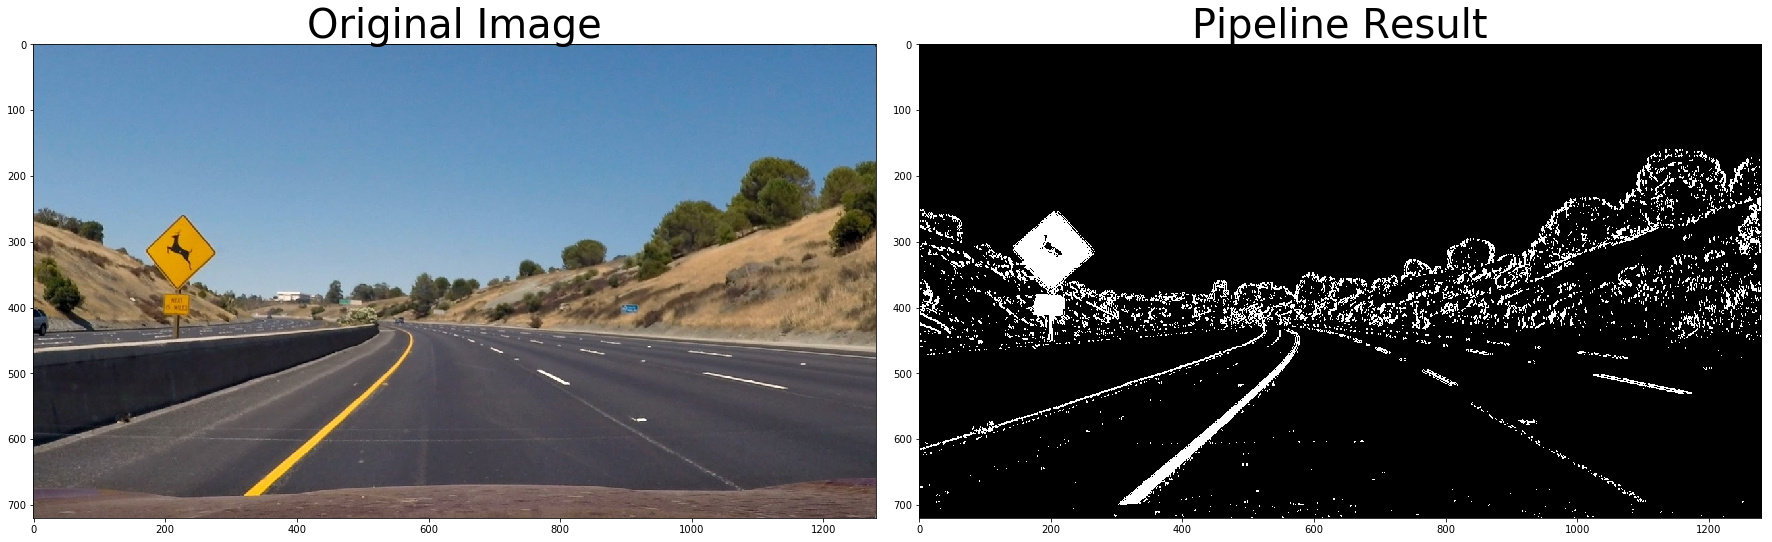

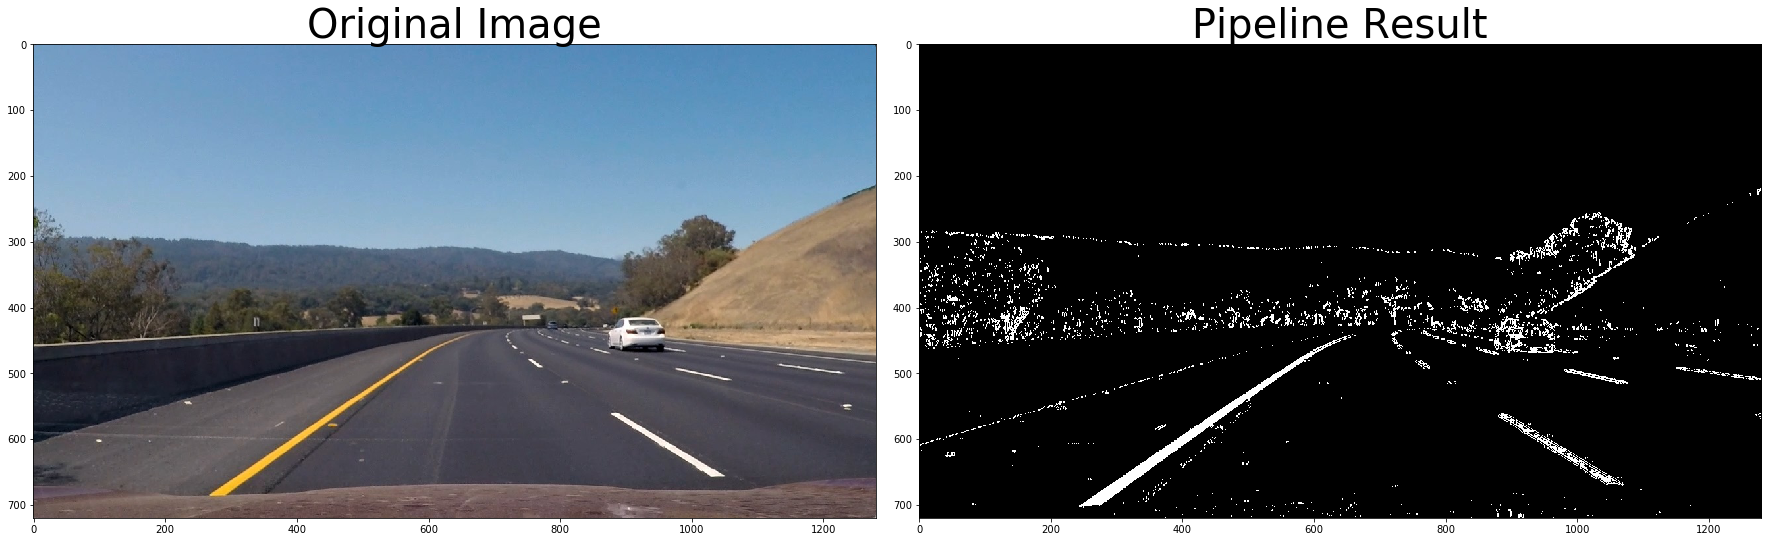

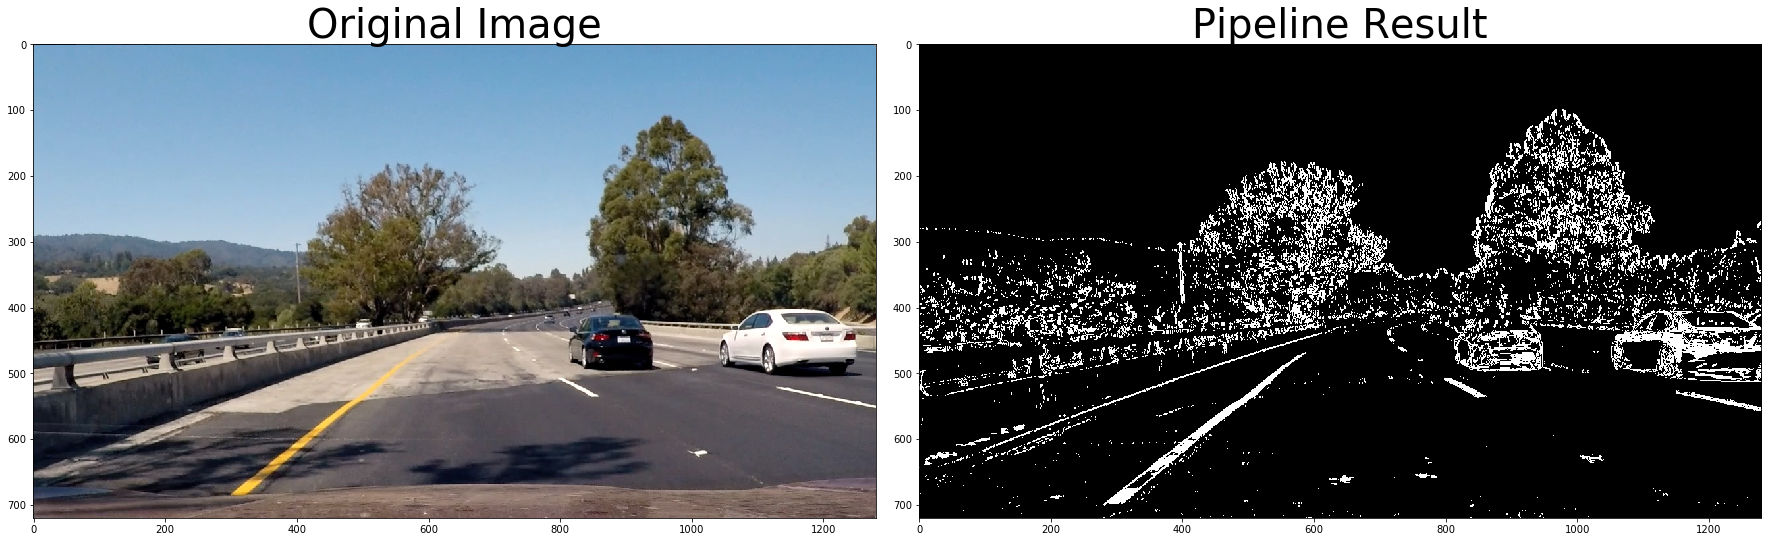

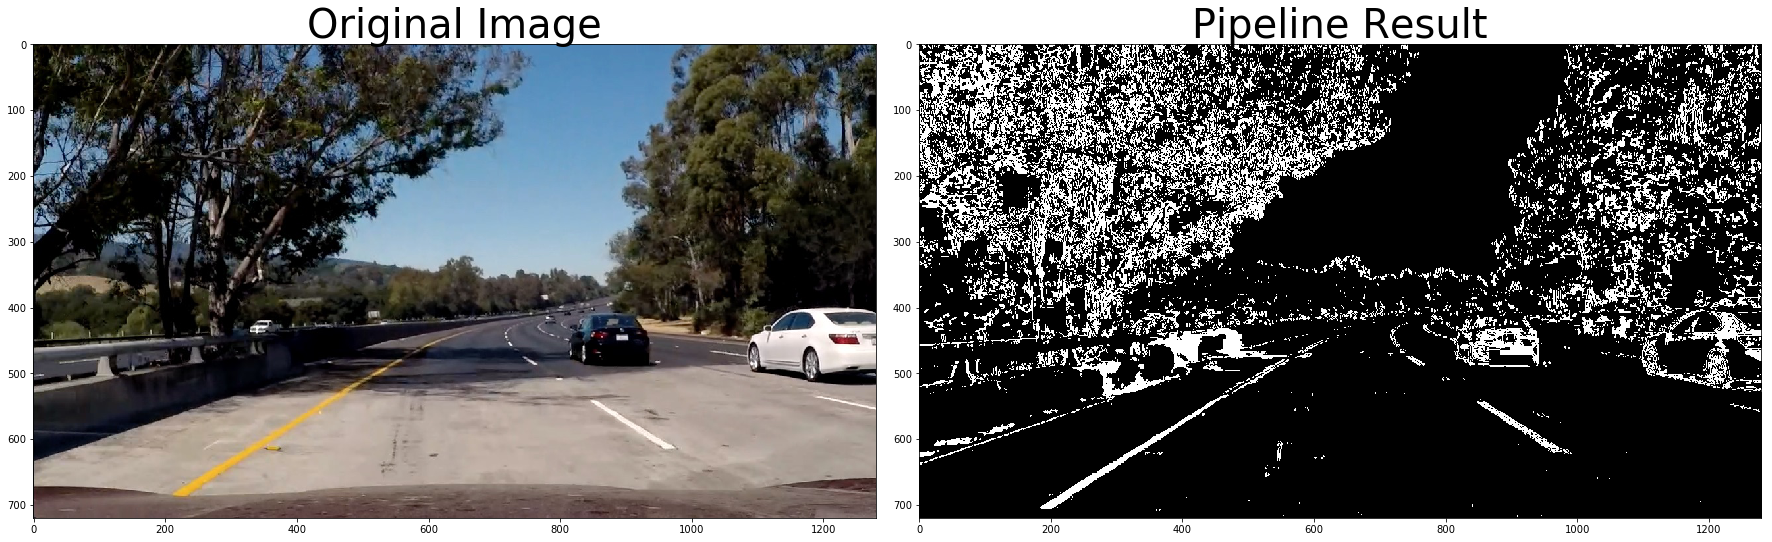

In [57]:
img1 = cv2.imread('test_images/test1.jpg')[...,::-1]
img2 = cv2.imread('test_images/test2.jpg')[...,::-1]
img3 = cv2.imread('test_images/test3.jpg')[...,::-1]
img4 = cv2.imread('test_images/test4.jpg')[...,::-1]
img5 = cv2.imread('test_images/test5.jpg')[...,::-1]
imagelist = [img1, img2, img3, img4, img5]
img_dst = []
result_binary = []

for i in range(len(imagelist)):
    
    img_dst.append(undistort_function(imagelist[i], objpoints, imgpoints))
    result_binary.append(pipeline(img_dst[i]))

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(imagelist[i])
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(result_binary[i],  cmap='gray')
    ax2.set_title('Pipeline Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# r_thresh = [140, 200]
# r_channel = img_dst[:,:,0]
# r_binary = np.zeros_like(r_channel)
# r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1

# plt.figure()
# plt.imshow(r_binary, cmap = 'gray')

# result_color, result_binary = pipeline(img_dst,(190, 255), (25, 100)  )

# # Plot the result
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
# f.tight_layout()

# ax1.imshow(img)
# ax1.set_title('Original Image', fontsize=40)

# ax2.imshow(result_binary,  cmap='gray')
# ax2.set_title('Pipeline Result', fontsize=40)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [63]:
# Mask outer image
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


    

(720, 1280)


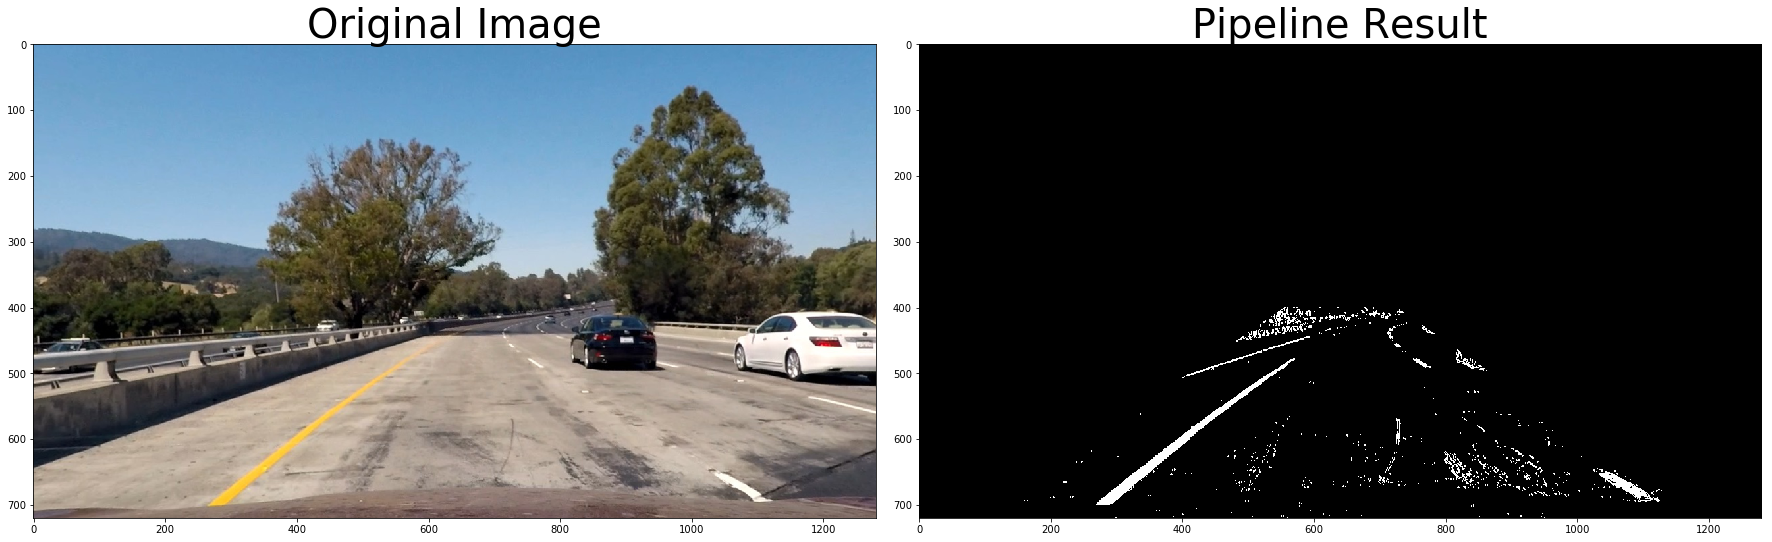

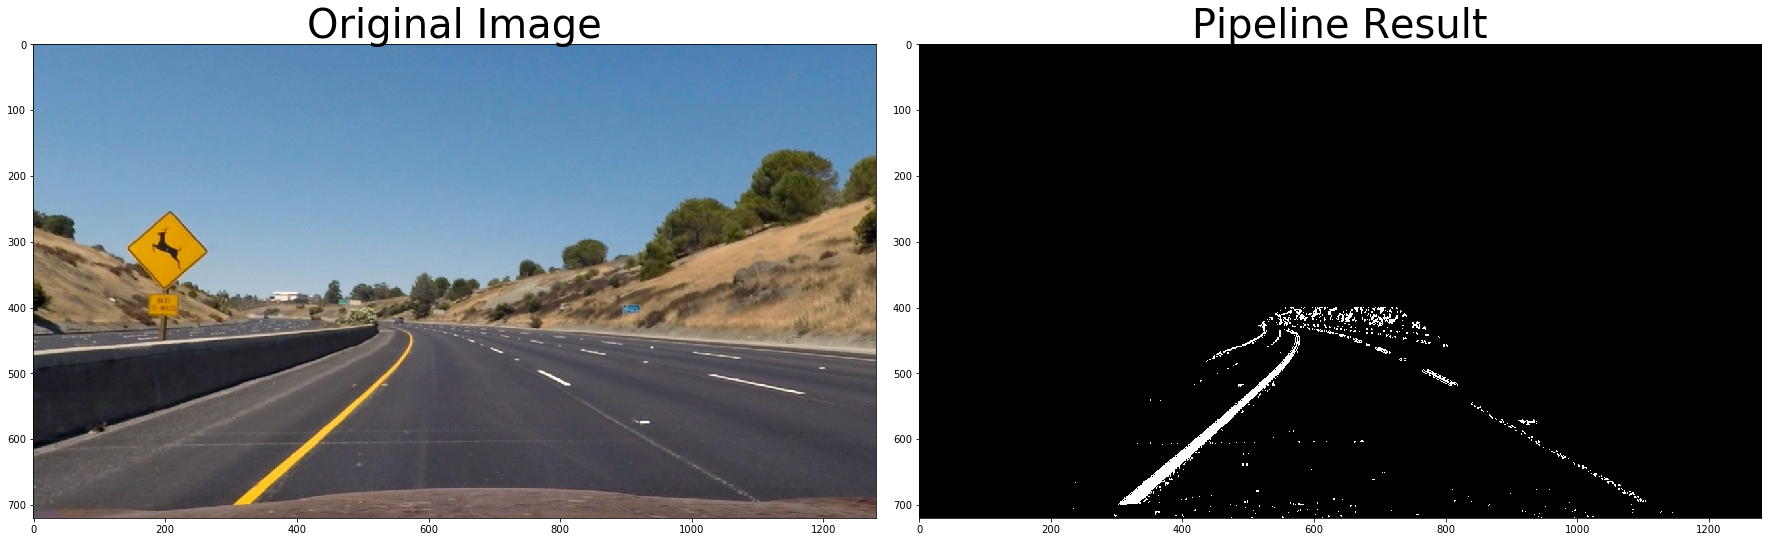

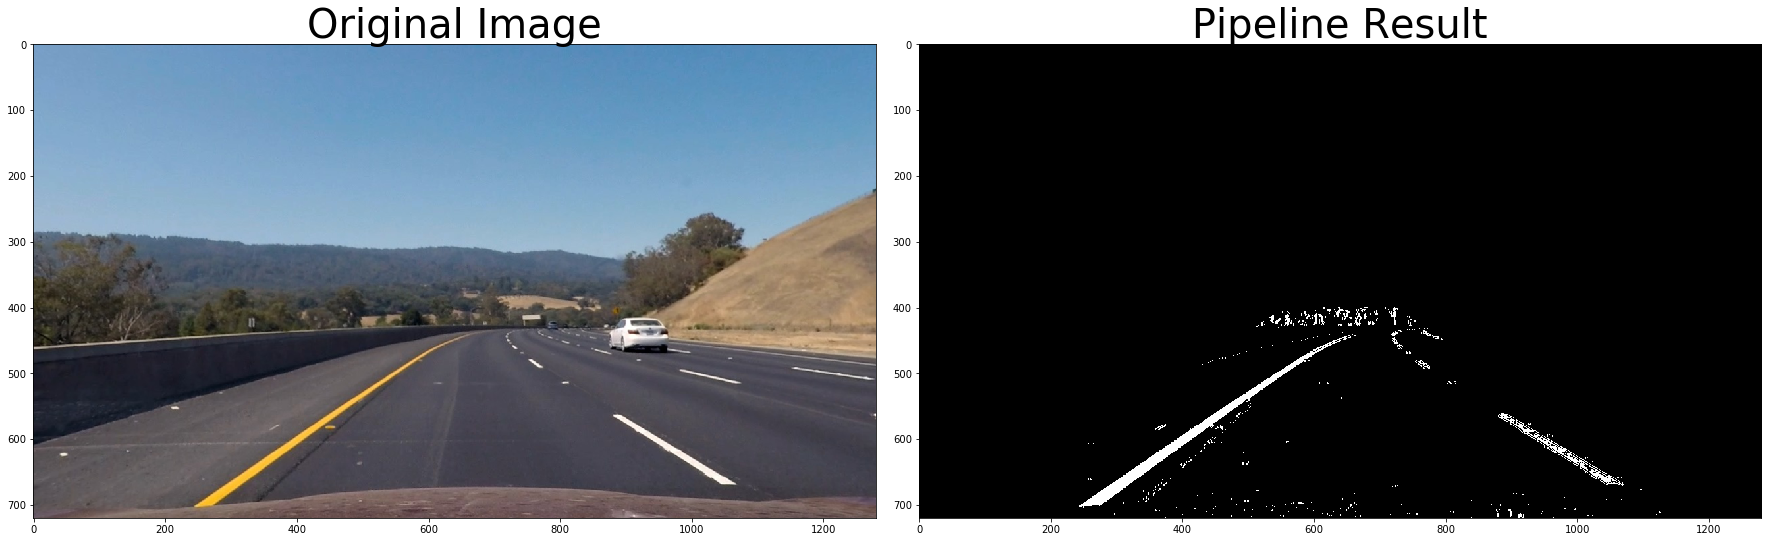

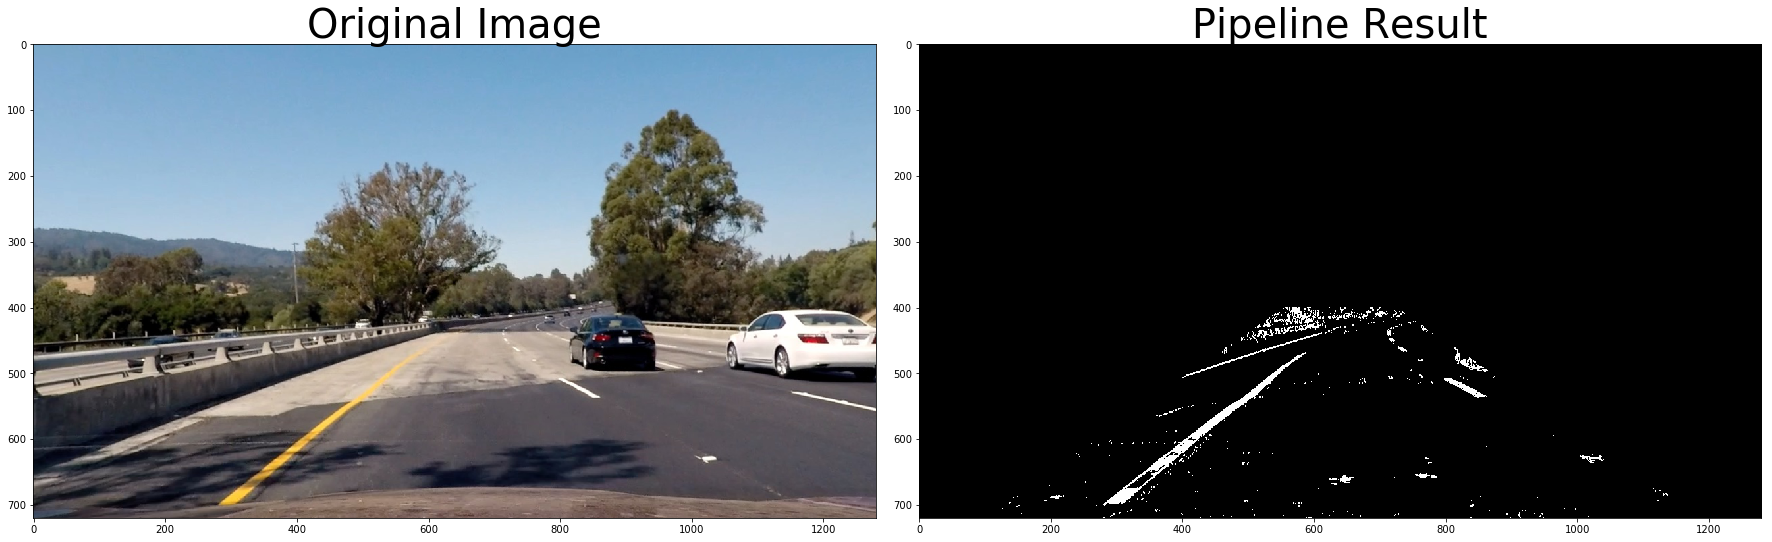

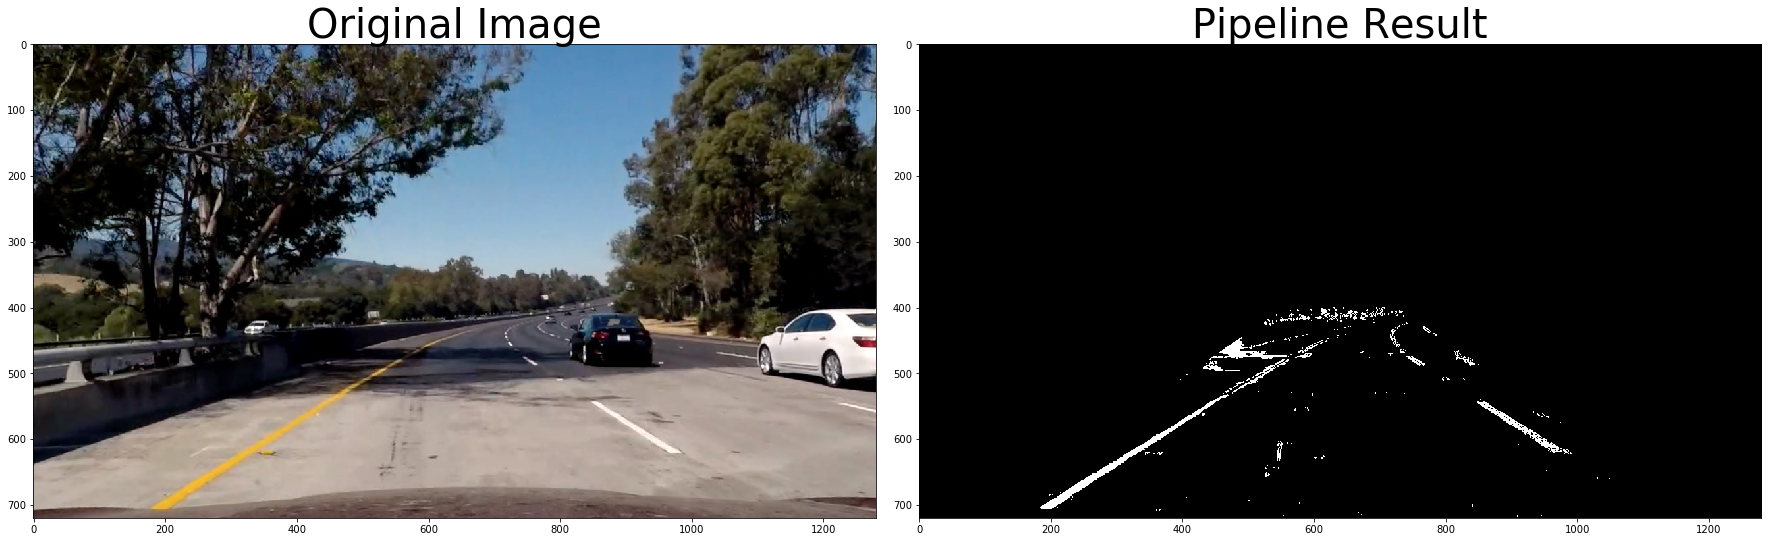

In [74]:
result_binary_masked = []
imshape = result_binary[0].shape
print(imshape)
vertices = np.array([[(imshape[1]/14,imshape[0]),(imshape[1]/2 - imshape[1]/15, imshape[0]/1.8), \
        (imshape[1]/2 + imshape[1]/15, imshape[0]/1.8), (imshape[1] - imshape[1]/14,imshape[0])]], dtype=np.int32) 

for img in result_binary:
    result_binary_masked.append(region_of_interest(img, vertices))
    
    
for i in range(len(result_binary)):
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img_dst[i], cmap='gray')
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(result_binary_masked[i], cmap='gray')
    ax2.set_title('Pipeline Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Perspective Transform

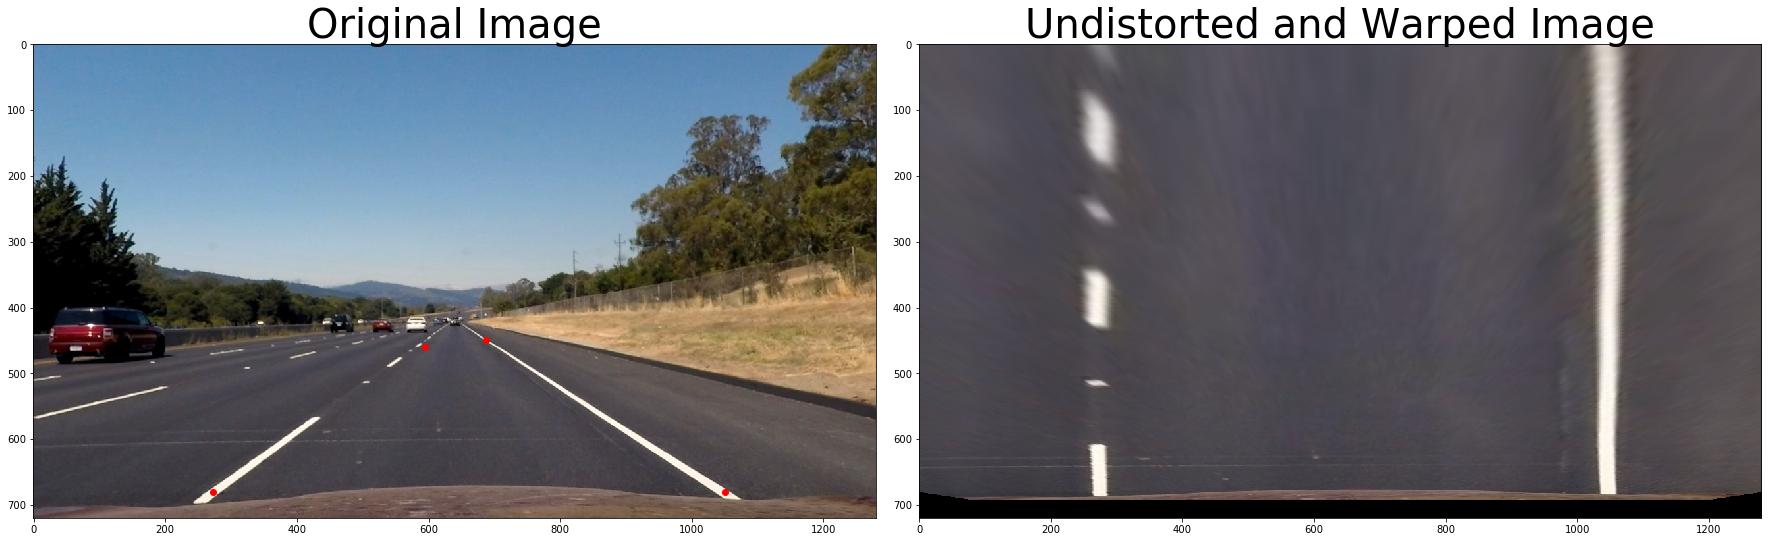

In [132]:
# mpig.imread(test)
import matplotlib.image as mpimg
img = mpimg.imread('test_images/straight_lines2.jpg')

undist = undistort_function(img, objpoints, imgpoints)




# plt.plot(1044, 680, 'ro', linewidth=2.0)
# plt.plot(259, 680, 'ro', linewidth=2.0)
# plt.plot(661, 436, 'ro', linewidth=2.0)
# plt.plot(616, 436, 'ro', linewidth=2.0)

# src = np.float32([[1044, 680], [661, 436], [616, 436], [259, 680]])
# dst = np.float32([[1044, 680], [1044, 0], [259, 0] , [259, 680]])

# src = np.float32([[1051, 680], [667, 436], [611, 436], [273, 680]])
# dst = np.float32([[1051, 680], [1051, 0], [273, 0] , [273, 680]])

src = np.float32([[1047, 680], [689, 450], [595, 450], [273, 680]])
dst = np.float32([[1047, 680], [1047, 0], [273, 0] , [273, 680]])

M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(undist, M, (img.shape[1], img.shape[0] ), flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=40)
ax1.plot(1051, 680, 'ro', linewidth=2.0)
ax1.plot(273, 680, 'ro', linewidth=2.0)
ax1.plot(687, 450, 'ro', linewidth=2.0)
ax1.plot(595, 460, 'ro', linewidth=2.0)

ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

src = np.float32([[1047, 680], [667, 436], [611, 436], [268, 680]])
dst = np.float32([[1047, 680], [1047, 0], [268, 0] , [268, 680]])